In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

import sys
sys.path.append('/home/oskar/nlll/NLP_Learning/NLP_Learning')  # Adjust the path according to your environment

from module import *
#from ..NLP_Learning.module import MultiheadAttention

torch.manual_seed(123)

/home/oskar/nlll/NLP_Learning/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GPT_config_124M = {
    'vocab_size': 50257,
    'context_length': 1024,
    'num_head': 12, 
    'emb_dim': 768,
    'n_layers': 12, 
    'drop_rate': 0.1,
    'qkv_bias': False
}

In [3]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], 
[0.55, 0.87, 0.66], 
[0.57, 0.85, 0.64], 
[0.22, 0.58, 0.33],
[0.77, 0.25, 0.10], 
[0.05, 0.80, 0.55]] 
)

batch = torch.stack((inputs, inputs), dim=0)
batch.shape

torch.Size([2, 6, 3])

In [4]:
batch_size, context_lengt, d_in = batch.shape

model = MultiheadAttention(d_in = 3, d_out=2, num_heads=2, context_lengt = context_lengt)
model(batch)

tensor([[[ 0.7732, -0.2205],
         [ 0.7652, -0.1832],
         [ 0.7639, -0.1720],
         [ 0.7435, -0.2019],
         [ 0.7517, -0.2030],
         [ 0.7341, -0.2182]],

        [[ 0.7732, -0.2205],
         [ 0.7652, -0.1832],
         [ 0.7639, -0.1720],
         [ 0.7435, -0.2019],
         [ 0.7517, -0.2030],
         [ 0.7341, -0.2182]]], grad_fn=<ViewBackward0>)

In [5]:
import tiktoken

encoding = tiktoken.encoding_for_model('gpt2')

text1 = "Every effort moves you"
text2 = "Every day holds a"

batch = []

for _ in [text1, text2]:
    batch.append(torch.tensor(encoding.encode(_)))

batch_sample = torch.stack(batch, dim=0)

print(batch_sample)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
model = DummyGPTmodule()
model(batch_sample)

tensor([[[-1.0047, -0.0617, -0.4195,  ..., -1.0968, -0.2360, -0.7827],
         [-0.2306, -0.4178,  0.2646,  ..., -0.6551,  0.9364,  0.8288],
         [ 0.4229,  1.2198, -0.2838,  ...,  2.3022,  0.0477, -0.0578],
         [ 0.3600,  1.5658,  0.0222,  ...,  0.1722, -1.1210, -0.5402]],

        [[-1.4045, -0.0061, -0.2265,  ..., -1.4541, -0.3286, -1.3925],
         [-0.2185, -0.9411,  0.2056,  ..., -0.2523, -0.2080,  0.1178],
         [ 0.1092,  0.8500, -0.3638,  ..., -0.0701, -0.2580,  0.6865],
         [ 0.2028,  0.0123,  0.3517,  ...,  0.7289, -0.8055, -0.9530]]],
       grad_fn=<UnsafeViewBackward0>)

In [10]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)

layer = nn.Sequential(
    nn.Linear(5, 6),
    nn.ReLU()
)

out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [16]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f'Mean: {mean},\nVar: {var}')

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>),
Var: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [18]:
out_norm = (out - mean) / torch.sqrt(var)
print(out_norm)
print(out_norm.mean(dim=-1, keepdim=True))
print(out_norm.var(dim=-1, keepdim=True))

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [26]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = 1e-5
        self.emb_dim = emb_dim
        self.scale = nn.Parameter(torch.ones(self.emb_dim))
        self.bias = nn.Parameter(torch.zeros(self.emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.bias


ln = LayerNorm(emb_dim=5)

out_ln = ln(batch_example)
print(out_ln)

print(out_ln.mean(dim=-1, keepdim=True))
print(out_ln.var(dim=-1, keepdim=True))

In [29]:
ln = LayerNorm(emb_dim=5)

out_ln = ln(batch_example)
print(out_ln)

print(out_ln.mean(dim=-1, keepdim=True))
print(out_ln.var(dim=-1, keepdim=True))

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
tensor([[1.2499],
        [1.2500]], grad_fn=<VarBackward0>)


In [39]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.\
        sqrt(torch.tensor(2.0 / torch.pi) * (x + 0.044715 * torch.pow(x, 3)))))

In [41]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
            ))

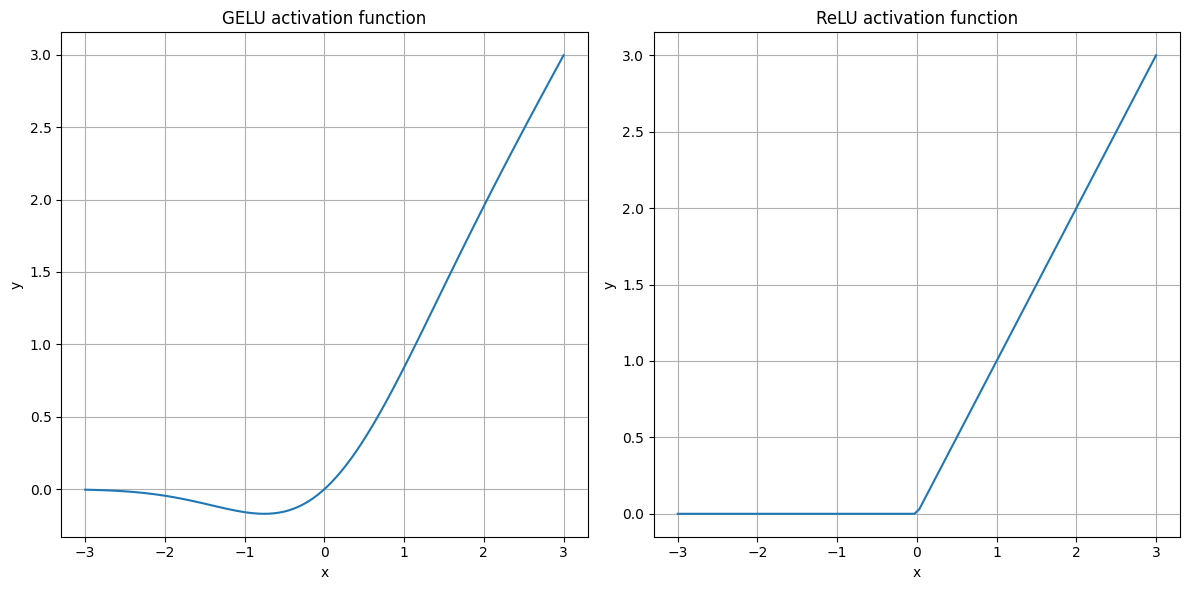

In [43]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3,3,100)

y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(12, 6))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU'])):
    plt.subplot(1, 2, i+1)
    plt.plot(x,y)
    plt.title(f'{label} activation function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [66]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_size, use_shortcut=False):
        super().__init__()
        self.use_shortcut = use_shortcut

        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0], layer_size[1]), GELU()),
            nn.Sequential(nn.Linear(layer_size[1], layer_size[2]), GELU()),
            nn.Sequential(nn.Linear(layer_size[2], layer_size[3]), GELU()),
            nn.Sequential(nn.Linear(layer_size[3], layer_size[4]), GELU()),
            nn.Sequential(nn.Linear(layer_size[4], layer_size[5]), GELU())
        ]
        )

    def forward(self, x):
        #compute
        for layer in self.layers:
            layer_out = layer(x)

            if self.use_shortcut and x.shape == layer_out.shape:
                x = x + layer_out
            else:
                x = layer_out
        return x
        

In [67]:
torch.set_printoptions(sci_mode=False)

In [68]:
layer_size = [3,3,3,3,3,3,1]
model = ExampleDeepNeuralNetwork(layer_size)
sample_input = torch.tensor([[1., 0., -1.]])

def print_gradient(model, x):
    output = model(x)
    target = torch.randn_like(output)

    loss = torch.nn.MSELoss()(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has a param {param.grad.abs().mean().item()}')

In [69]:
print_gradient(model, samle_input)

layers.0.0.weight has a param 0.0012179916957393289
layers.1.0.weight has a param 0.0030874121002852917
layers.2.0.weight has a param 0.0020798740442842245
layers.3.0.weight has a param 0.011124690063297749
layers.4.0.weight has a param 0.021914280951023102


In [70]:
layer_size = [3, 3, 3, 3, 3, 1]
model = ExampleDeepNeuralNetwork(layer_size, use_shortcut=True)

print_gradient(model, samle_input)

layers.0.0.weight has a param 0.03952733799815178
layers.1.0.weight has a param 0.052864931523799896
layers.2.0.weight has a param 0.09154993295669556
layers.3.0.weight has a param 0.07208192348480225
layers.4.0.weight has a param 0.5970112085342407
